# Segmentation for multiclass population of objects

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm.auto import tqdm
from skimage.io import imsave, imread
import json
from scipy import ndimage as nd
import glob

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load images

In [3]:
# define experiment ID and select a position
expt = 'ND0013'
pos = 'Pos7'
# point to where the data is
root_dir = '/home/nathan/data/kraken/ras/'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
# lazily load images
images = DaskOctopusLiteLoader(image_path, 
                               remove_background = True)
images.channels

[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK_RFP: 97>,
 <Channels.MASK_GFP: 98>,
 <Channels.MASK: 99>]

Set segmentation channel and load test image

In [4]:
# set test image index
frame = 0
# load 2 single-channel test images 
img = images['gfp'][frame]
# rfp = images['rfp'][frame]
# # create 2-channel image
# img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
# img[:,:,0] = gfp
# img[:,:,1] = gfp
# img.shape

## 2. Load model and test segment single image 

In [5]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')
model

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

### 2.1 Test run and display initial results

In [6]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
# plt.clf()
# plt.subplot(1,2,1)
# plt.imshow(normalize(img[:,:,0]))
# plt.axis("off")
# plt.title("input image")
# plt.subplot(1,2,2)
# plt.imshow(render_label(labels, img = img))
# plt.axis("off")
# plt.title("prediction + input overlay")
# plt.show()

TypeError: percentile() got an unexpected keyword argument dict_keys(['axis', 'keepdims'])

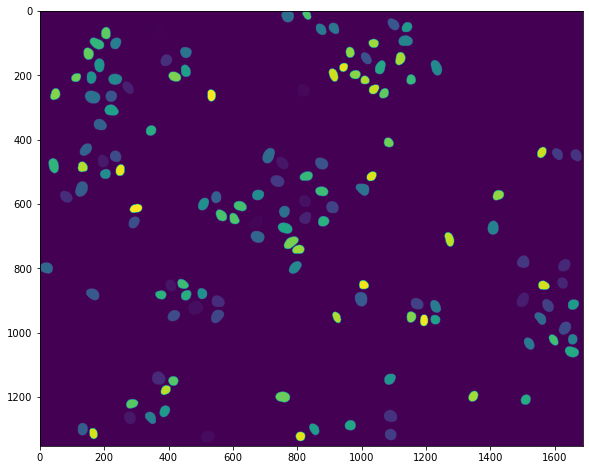

In [16]:
plt.imshow(labels)

### 2.2 Format mask so that it contains multiclass information 
(i.e. pixel value = class identity)

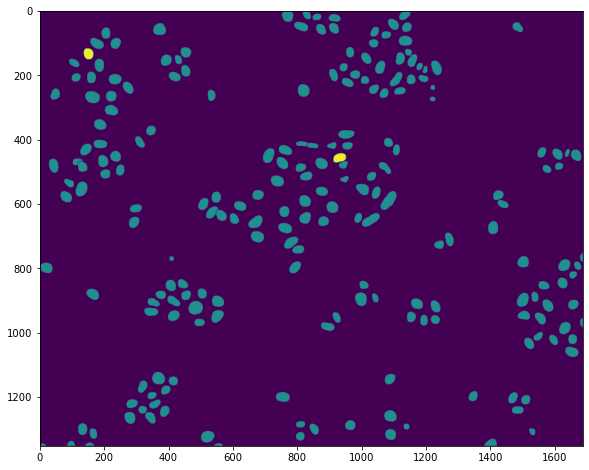

In [10]:
# format 2channel mask image 
mask = np.zeros(labels.shape)
# make multiclass mask from details dict
for cell_ID, class_label in enumerate(details['class_id'], 1):
    #needs erosion step to stop merging of labels
    segment = nd.binary_erosion(labels==cell_ID)
    mask[segment] = class_label
    # set background to zero
    mask[labels == 0] = 0
plt.imshow(mask)

## 3. Batch segment a whole stack of images

When you segment a whole data set you do not want to apply any image transformation. This is so that when you load images and masks later on you can apply the same transformation. You can apply a crop but note that you need to be consistent with your use of the crop from this point on, otherwise you'll get a shift. 

In [9]:
reference_channel = 'gfp'
root_dir = '/home/nathan/data/kraken/ras/'

In [8]:
seg_model = model
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, binary_dilation, remove_small_objects, remove_small_holes

In [178]:
%%time
for expt in tqdm(sorted(['ND0013'])):
    pos_list = ['Pos7']#sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                         if 'Pos' in pos 
#                         and os.path.isdir(f'{root_dir}/{expt}/{pos}')],
#                         key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
    for pos in tqdm(pos_list):

        print('Starting experiment position:', expt, pos)
        # load images
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
        images = DaskOctopusLiteLoader(image_path, 
                                       remove_background = True)

        # iterate over images filenames 
        for frame, fn in tqdm(enumerate(images.files('gfp')),total = len(images.files('gfp'))):
            # load two seperate images
            if os.path.exists(fn.replace('channel001', 'channel097')):
                continue
            gfp = imread(fn)
            # predict gfp labels with a higher threshold as the fl. signal is strong
            labels, details = seg_model.predict_instances(normalize(gfp), prob_thresh=0.75)
            # create empty mask image
            mask = np.zeros(labels.shape, dtype = np.uint8)
            # remove any small, unrealistically nuclear objects from seg output
            labels = remove_small_objects(labels, min_size = 200)
            ### image post processing, start at 1 to skip background label
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = labels == i
                seg_props = regionprops(label(segment), cache = False)
                ### if segment exists, subject to exclusion criteria
                if seg_props:
                    if 2000 <= seg_props[0].area or seg_props[0].eccentricity > 0.95:
                        ### dont bother eroding the large ras cyto masks as will add time
                        #segment = binary_erosion(segment)
                        mask[segment] = 3
                    else:
                        segment = binary_erosion(segment)
                        mask[segment] = 1

            # now do the same for the rfp channel
            rfp = imread(fn.replace('channel001', 'channel002'))   
            # predict labels a much lower threshold as rfp signal is dim
            labels, details = seg_model.predict_instances(normalize(rfp), prob_thresh=0.2)
            
            ### remove small objects (low thresh picks up hot pixels) also reduce number of iterations needed for individual binary erosion
            labels = remove_small_objects(labels, min_size = 200)
            
            ### iterate over individual segments, eroding and reassigning label to not merge
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = labels == i
                segment = binary_erosion(segment)
                ## add to main mask
                mask[segment] = 2

            # set filename as mask format (channel099)
            fn = ((images.files('gfp')[frame])).replace('channel001', 'channel097')
            #save out labelled image
            imsave(fn, mask.astype(np.uint8), check_contrast=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Starting experiment position: ND0013 Pos7


  0%|          | 0/2797 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [175]:
labels, details = seg_model.predict_instances(normalize(gfp), prob_thresh=0.5)


In [176]:
%%time
labels = remove_small_objects(labels, min_size = 200)
mask = np.zeros(labels.shape, dtype = np.uint8)
### image post processing 
### start at 1 to skip background label
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment), cache = False)
    if seg_props:
        if 2000 <= seg_props[0].area or seg_props[0].eccentricity > 0.95:
            segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            segment = binary_erosion(segment)
            mask[segment] = 1

CPU times: user 5.81 s, sys: 116 ms, total: 5.92 s
Wall time: 5.92 s


In [173]:
%%time
labels = remove_small_objects(labels, min_size = 200)
mask = np.zeros(labels.shape, dtype = np.uint8)
### image post processing 
### start at 1 to skip background label
for i in range(1, np.amax(labels)):
    #needs erosion step to stop merging of labels
    segment = labels == i
    seg_props = regionprops(label(segment), cache = False)
    if seg_props:
        if 2000 <= seg_props[0].area or seg_props[0].eccentricity > 0.95:
            #segment = binary_erosion(segment)
            mask[segment] = 3
        else:
            segment = binary_erosion(segment)
            mask[segment] = 1
    
#mask = remove_small_objects(mask, min_size = 200)

CPU times: user 5.56 s, sys: 52 ms, total: 5.61 s
Wall time: 5.61 s


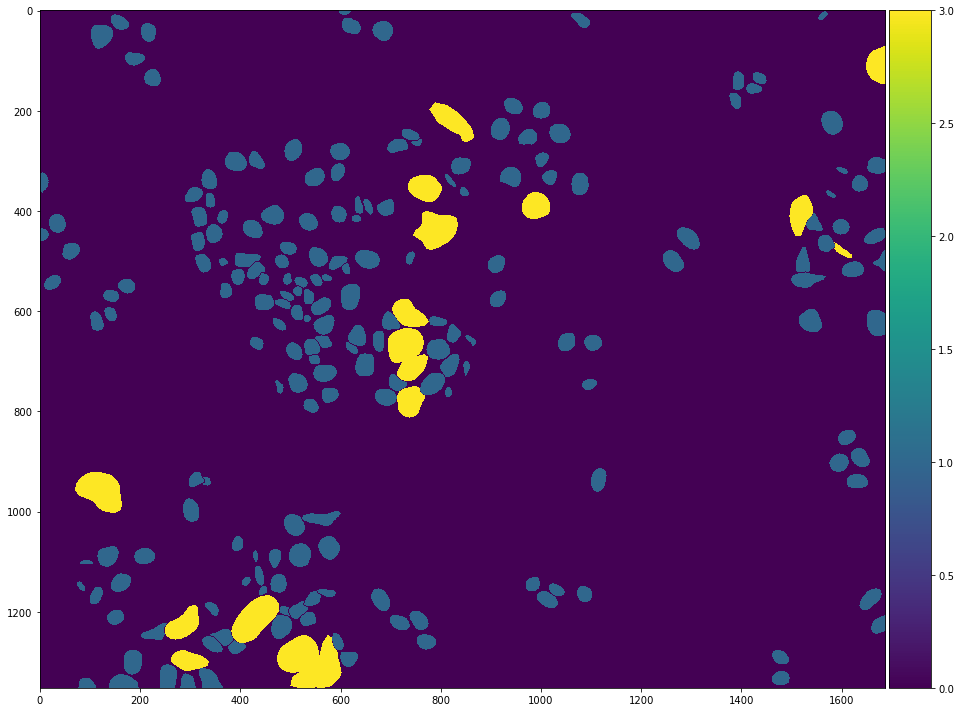

In [174]:
imshow(mask)

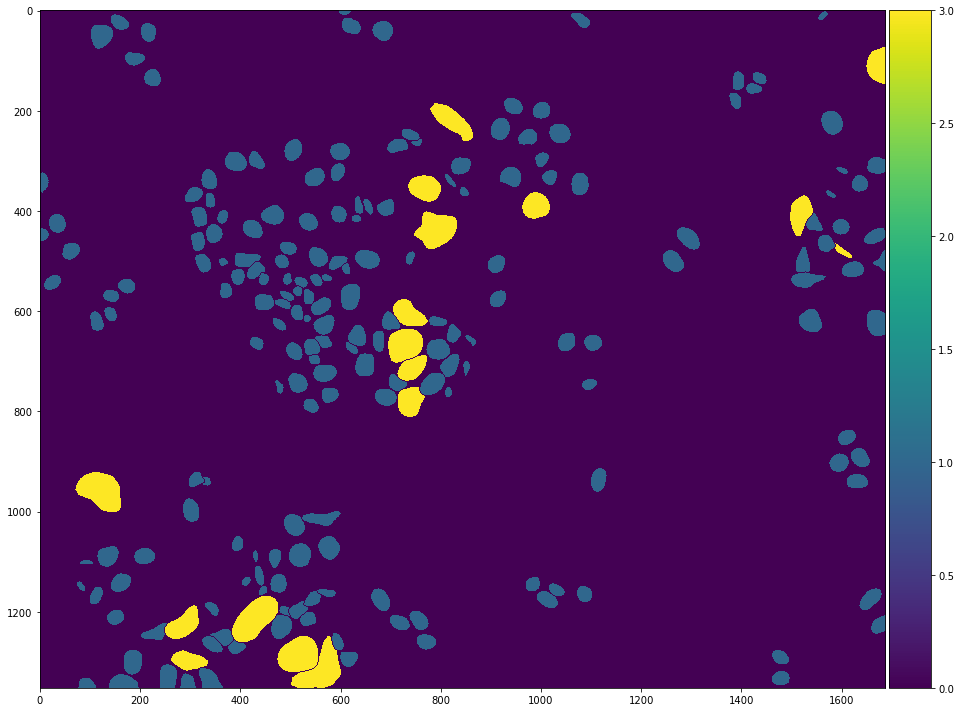

In [177]:
imshow(mask)

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


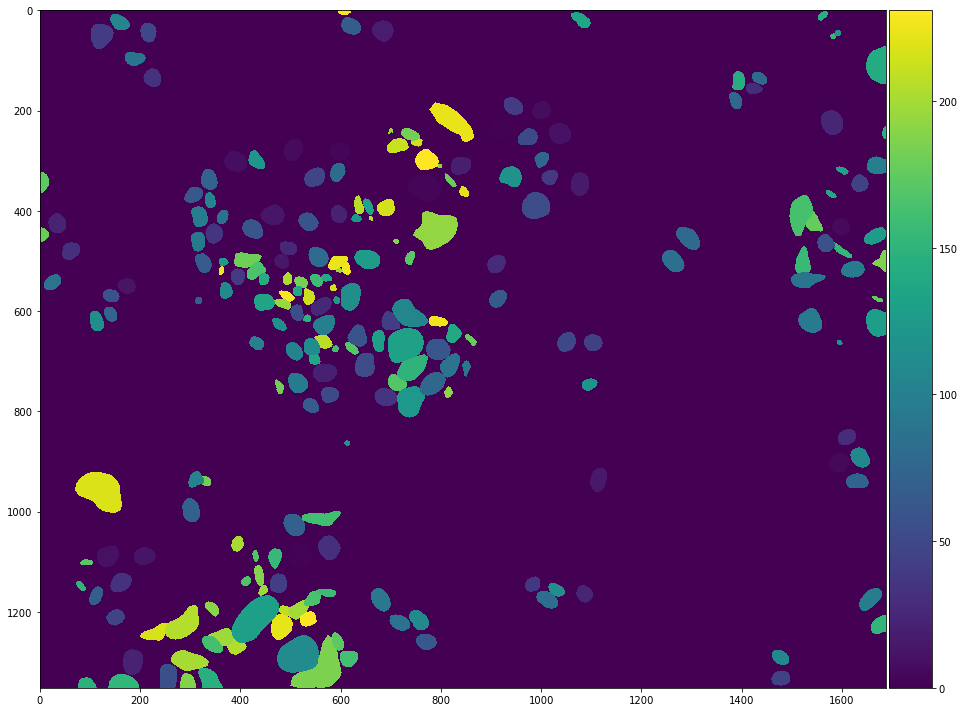

In [139]:
imshow(remove_small_objects(labels))

In [128]:
np.amax(labels)

231

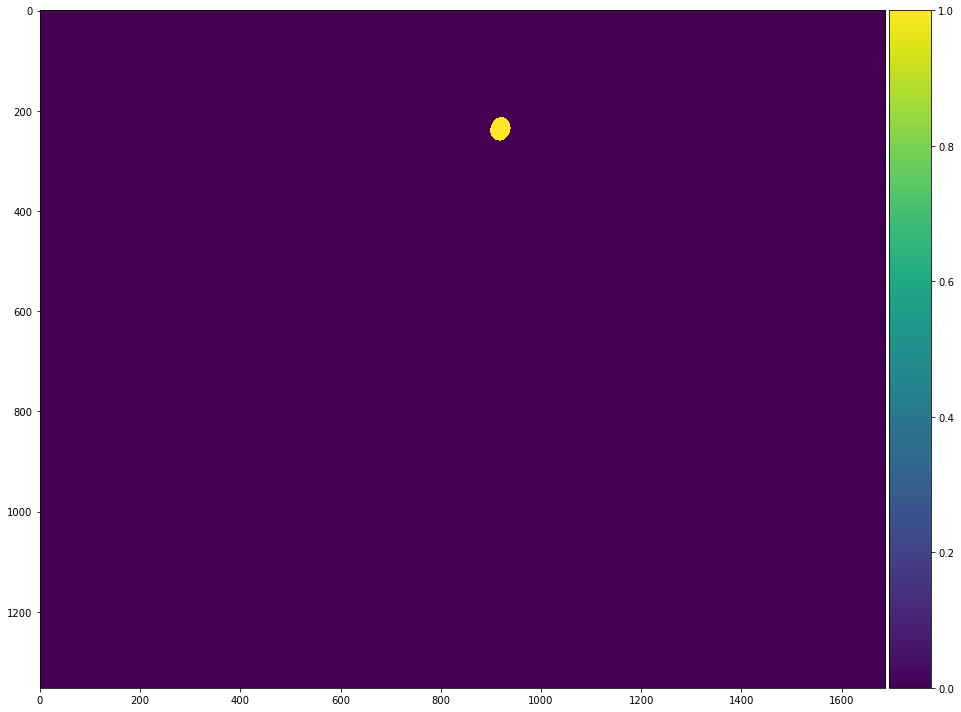

In [130]:
imshow((labels == 1).astype(int))

In [115]:
seg_props = regionprops(label(labels == 212))

In [118]:
seg_props.area

AttributeError: 'list' object has no attribute 'area'

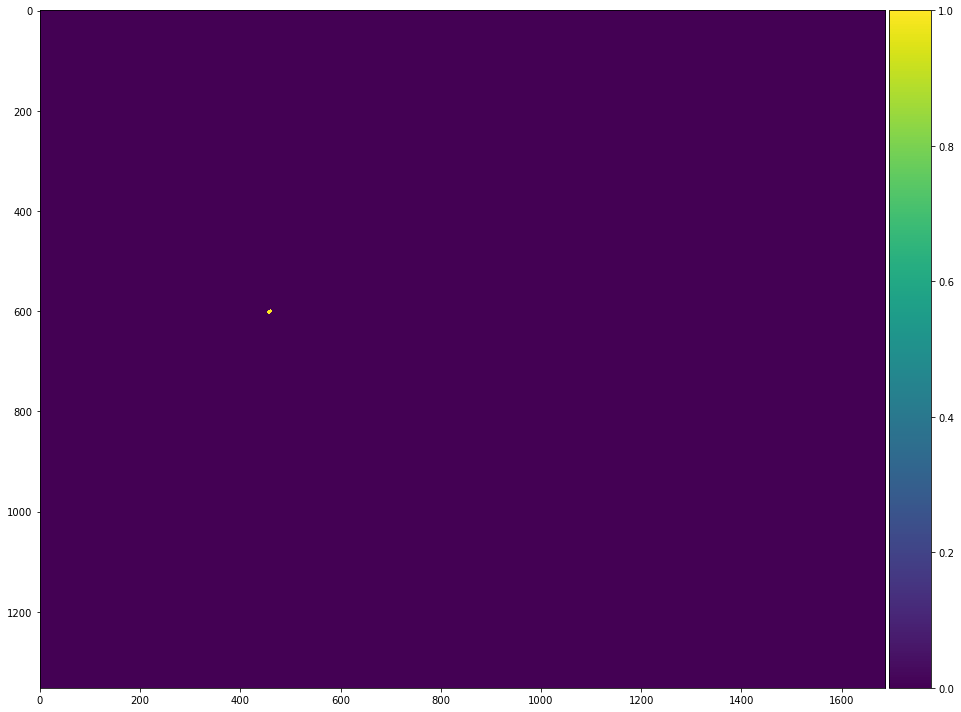

In [100]:
imshow((labels==211).astype(int))

In [95]:
i

210

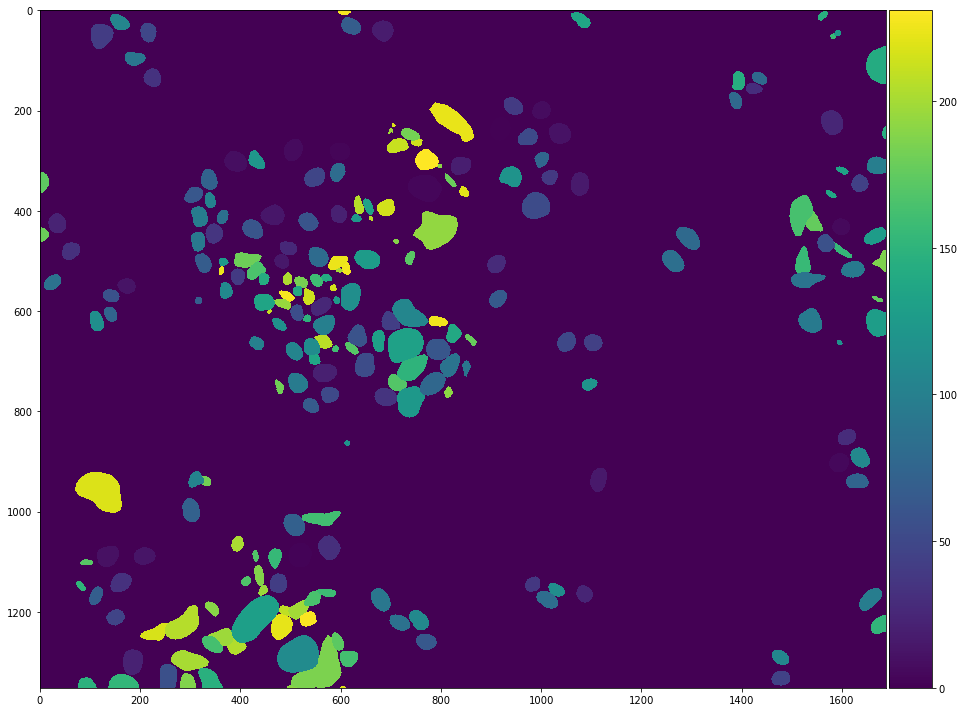

In [84]:
imshow(labels)

In [85]:
np.amax(labels)

231

In [93]:
for i in range(1, np.amax(labels)):
    ## i-1 for region props as it doesnt count background (i=0) as region
    print(i, regionprops(labels)[i-1].area)

1 1473
2 1814
3 1181
4 2774
5 1215
6 935
7 1321
8 1057
9 1489
10 1499
11 1460
12 888
13 1201
14 1494
15 693
16 1266
17 1368
18 1410
19 1181
20 1434
21 921
22 1676
23 1133
24 889
25 1757
26 1146
27 787
28 1077
29 942
30 598
31 1668
32 1028
33 1271
34 1027
35 1313
36 1098
37 749
38 751
39 773
40 1074
41 1795
42 1114
43 1063
44 988
45 910
46 908
47 907
48 1227
49 1016
50 1136
51 934
52 1068
53 2438
54 1612
55 698
56 1524
57 981
58 703
59 1284
60 1151
61 1225
62 1631
63 926
64 1044
65 970
66 757
67 989
68 1076
69 772
70 184
71 1499
72 1320
73 1078
74 1110
75 628
76 690
77 1782
78 685
79 1563
80 594
81 1282
82 888
83 1122
84 1428
85 524
86 1026
87 845
88 1346
89 1566
90 923
91 350
92 1378
93 939
94 1786
95 1238
96 1291
97 1104
98 1370
99 1148
100 1359
101 591
102 553
103 747
104 943
105 938
106 2656
107 823
108 1204
109 1169
110 697
111 4864
112 899
113 674
114 1839
115 916
116 529
117 94
118 106
119 1396
120 587
121 866
122 266
123 2599
124 265
125 138
126 182
127 1596
128 1102
129 1862
13

In [92]:
i

230

In [87]:
len(regionprops(labels))

230

In [88]:
len(range(1, len(regionprops(labels))))

229

In [65]:
for i in range(len(regionprops(labels))):
    if regionprops(labels)[i].area < 200:
        print(i, regionprops(labels)[i].area)

49 93
81 198
101 167
107 102
114 82
133 56
143 91
145 90
151 116
154 77
165 99
171 101
173 125
174 131
178 92
180 147
184 59
185 127
186 102
194 88
195 63
197 80


In [66]:
for i in range(len(regionprops(label(remove_small_objects(mask, min_size = 200))))):
    if regionprops(label(remove_small_objects(mask, min_size = 200)))[i].area < 200:
        print(i, regionprops(label(remove_small_objects(mask, min_size = 200)))[i].area)

46 36
68 172
73 173
79 62
81 60
83 155
84 93
85 156
93 89
96 54
98 124
100 49
111 81
117 65
122 64
128 56
130 71
131 34
143 110
148 69


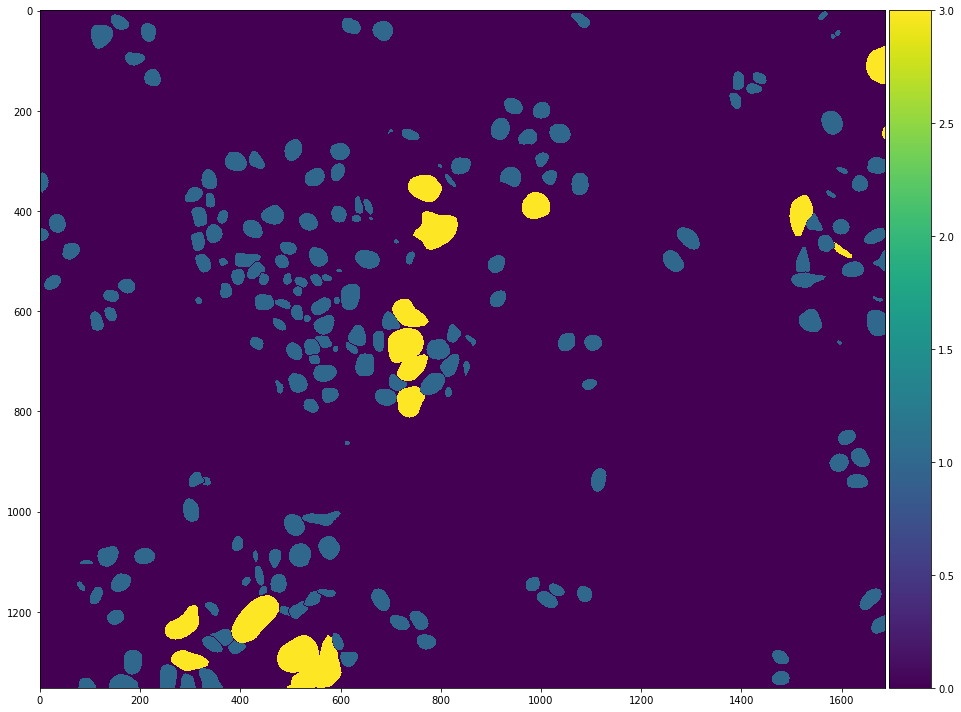

In [71]:
imshow(mask)

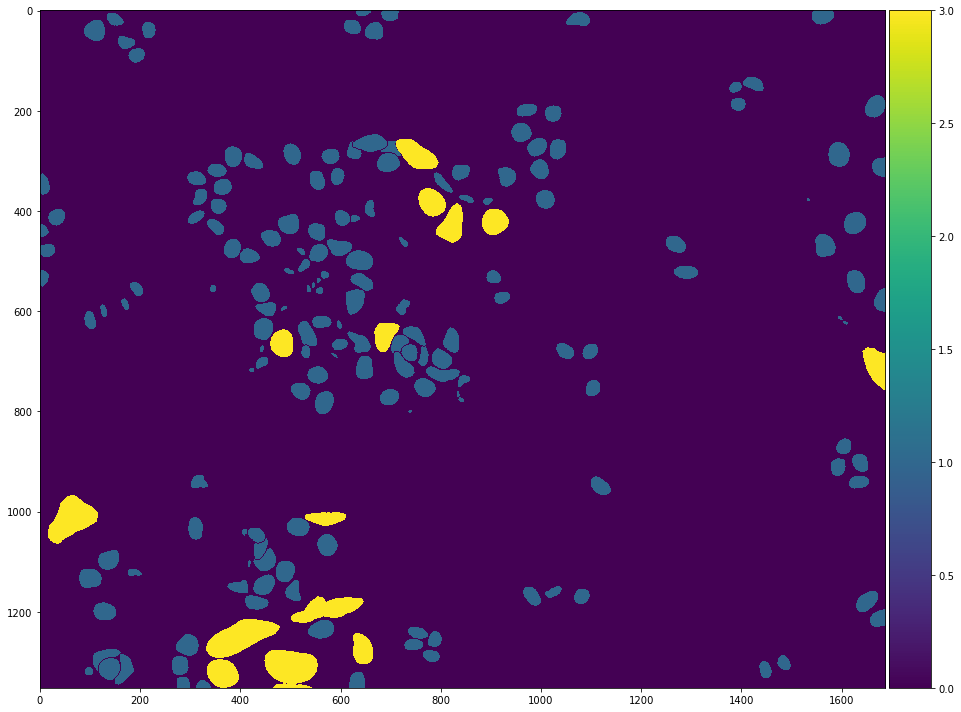

In [63]:
imshow(remove_small_objects(mask, min_size = 200))

In [56]:
%%time
for expt in tqdm(sorted(['ND0013'])):
    pos_list = ['Pos7']#sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                         if 'Pos' in pos 
#                         and os.path.isdir(f'{root_dir}/{expt}/{pos}')],
#                         key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
    for pos in tqdm(pos_list):

        print('Starting experiment position:', expt, pos)
        # load images
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
        images = DaskOctopusLiteLoader(image_path, 
                                       remove_background = True)


        # iterate over images filenames 
        for frame, fn in tqdm(enumerate(images.files('gfp')),total = len(images.files('gfp'))):
            # load two seperate images
#             if os.path.exists(fn.replace('channel001', 'channel099')):
#                 continue
            gfp = imread(fn)
            # predict labels using 2 instances of the model with different params
            labels, details = seg_model.predict_instances(normalize(gfp), prob_thresh=0.5)
            # format 2channel mask image 
            mask = np.zeros(labels.shape, dtype = np.uint8)
            
            ## 
            
            ### image post processing 
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = labels == i
                seg_props = regionprops(label(segment))[0]
                if 2000 <= seg_props.area or seg_props.eccentricity > 0.95:
                    #segment = binary_erosion(segment)
                    mask[segment] = 3
                else:
                    segment = binary_erosion(segment)
                    mask[segment] = 1
            
            mask = remove_small_objects(mask, min_size = 200)

            # now do the same for the rfp channel
            rfp = imread(fn.replace('channel001', 'channel002'))   
            # predict labels using 2 instances of the model with different params
            labels, details = seg_model.predict_instances(normalize(rfp), prob_thresh=0.2)
            
            ### remove small objects to reduce number of iterations needed for individual binary erosion
            labels = remove_small_objects(labels, min_size = 50)
            
            ### iterate over individual segments, eroding and reassigning label to not merge
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = labels == i
                segment = binary_erosion(segment)
                ## add to main mask
                mask[segment] = 2
                    
            #rfp_mask = remove_small_objects(binary_erosion(labels), min_size = 150).astype(np.uint8)*2 
            
            ### image post processing 
#             for i in range(1, np.amax(labels)):
#                 #needs erosion step to stop merging of labels
#                 segment = labels == i
#                 seg_props = regionprops(label(segment))[0]
#                 if 4000 <= seg_props.area or seg_props.area <= 100 or seg_props.eccentricity > 0.95:
#                     #segment = binary_erosion(segment)
#                     mask[segment] = 3
#                 else:
#                     segment = binary_erosion(segment)
#                     mask[segment] = 2
                    
# #             mask = imread(fn)
# #             gfp_mask = mask == 1
# #             rfp_mask = mask == 2

#             rfp_mask = remove_small_objects(rfp_mask, min_size=150).astype(np.uint8)*2
#             gfp_mask = label(remove_small_objects(remove_small_holes(gfp_mask), min_size=150))

#             for i in range(1, np.amax(gfp_mask)+1):
#                 #DOEESNT- already eroded ## needs erosion step to stop merging of labels
#                 segment = gfp_mask == i
#                 seg_props = regionprops(label(segment))[0]
#                 if 3000 <= seg_props.area or seg_props.eccentricity > 0.95 or seg_props.area < (0.9*seg_props.filled_area):
#                     #segment = binary_erosion(segment)
#                     gfp_mask[segment] = 3
#                 else:
#                     #segment = binary_erosion(segment)
#                     gfp_mask[segment] = 1

#             mask = gfp_mask.astype(np.uint8) + rfp_mask.astype(np.uint8)

#             imsave(fn.replace('channel098', 'channel099'), mask.astype(np.uint8), check_contrast=False)

            # set filename as mask format (channel099)
            fn = ((images.files('gfp')[frame])).replace('channel001', 'channel096')
            #save out labelled image
            imsave(fn, mask.astype(np.uint8), check_contrast=False)

            

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Starting experiment position: ND0013 Pos7


  0%|          | 0/2797 [00:00<?, ?it/s]

IndexError: list index out of range

In [15]:
from skimage.io import imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

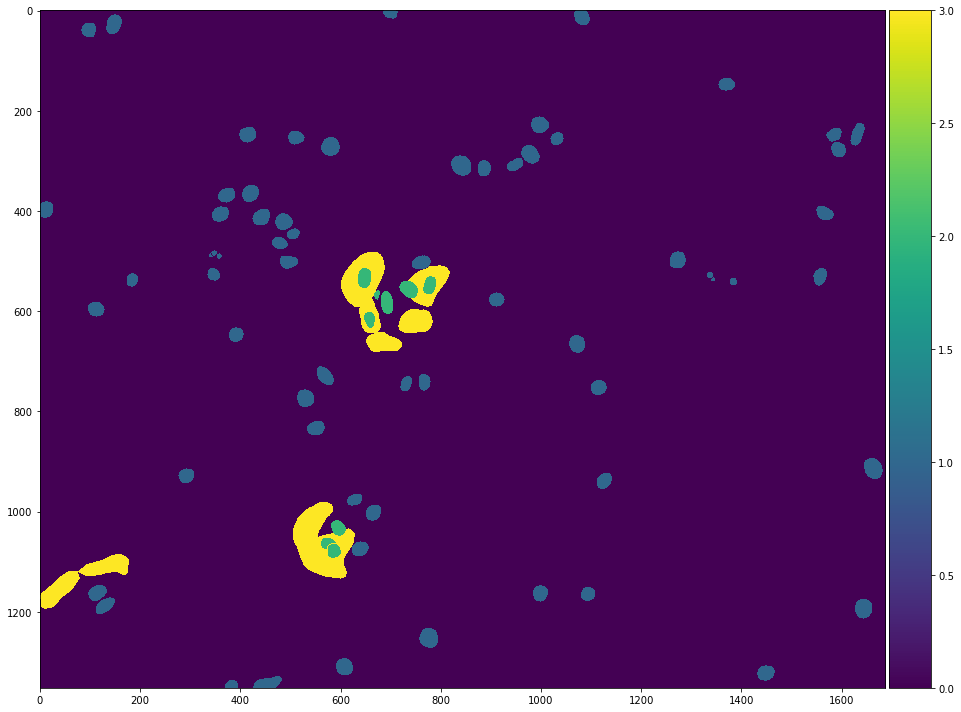

In [48]:
imshow(mask)

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


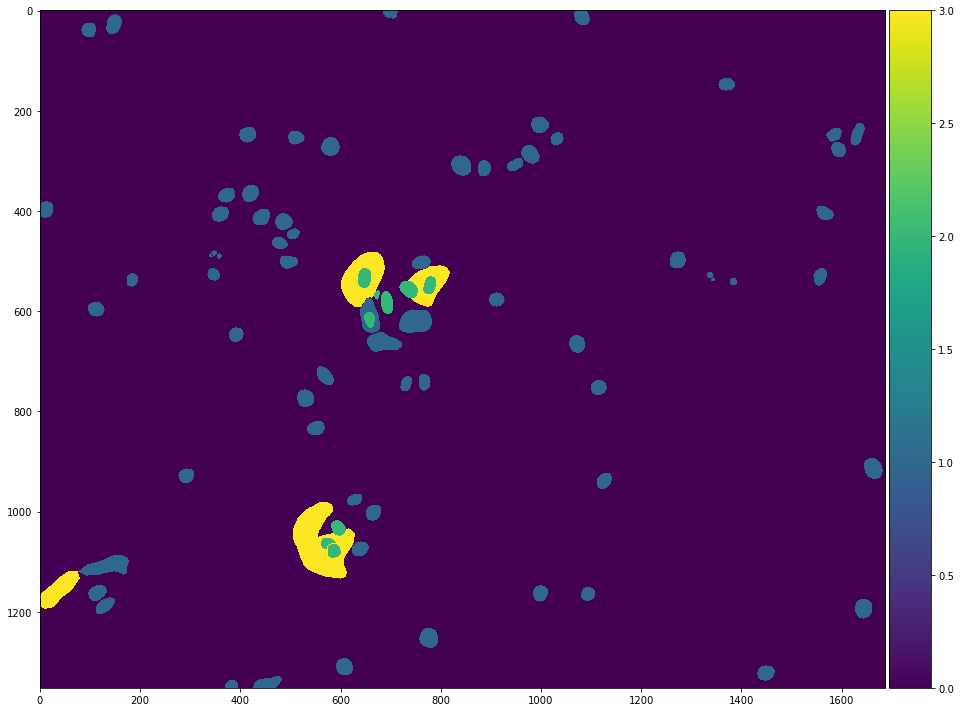

In [43]:
imshow(mask)

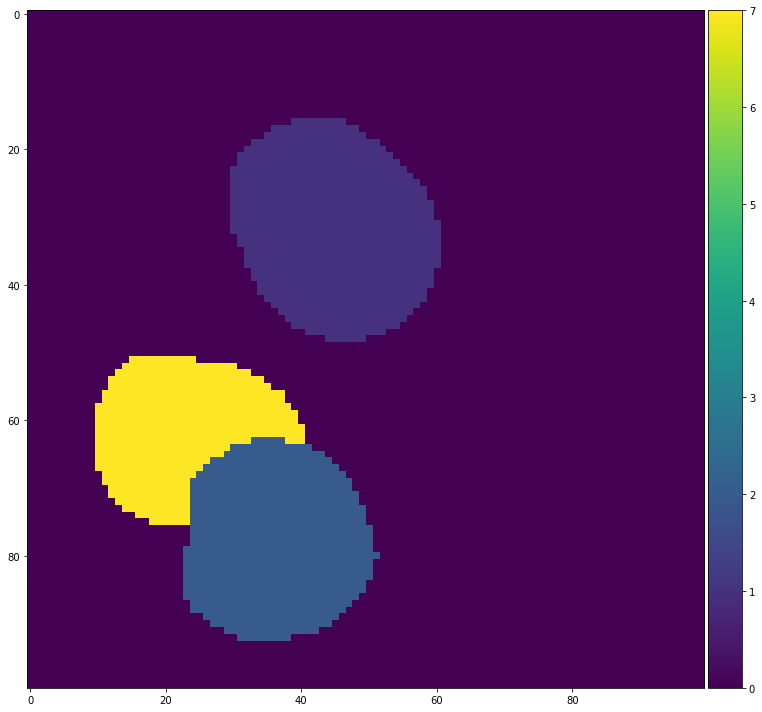

In [36]:
imshow(labels[1000:1100,550:650])

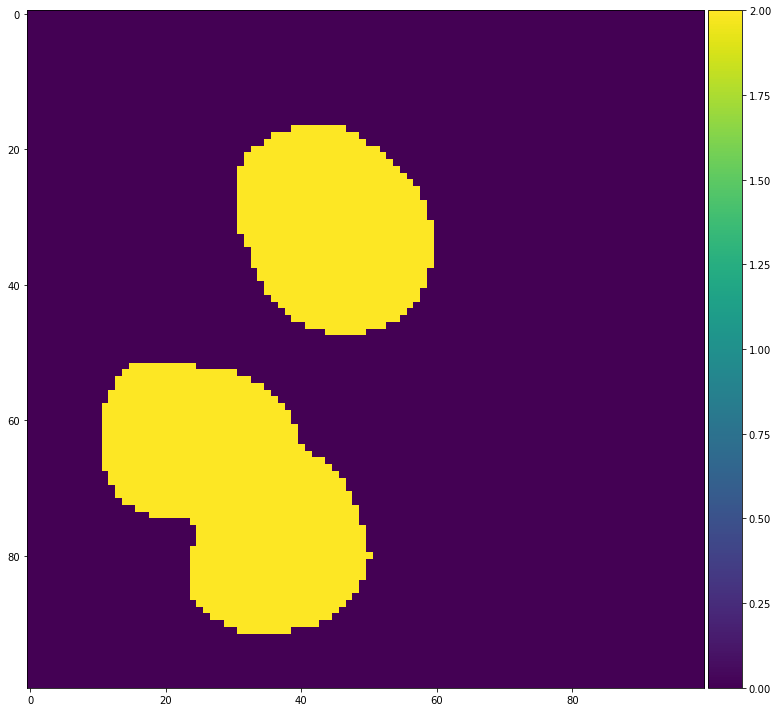

In [37]:
imshow(rfp_mask[1000:1100,550:650])

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


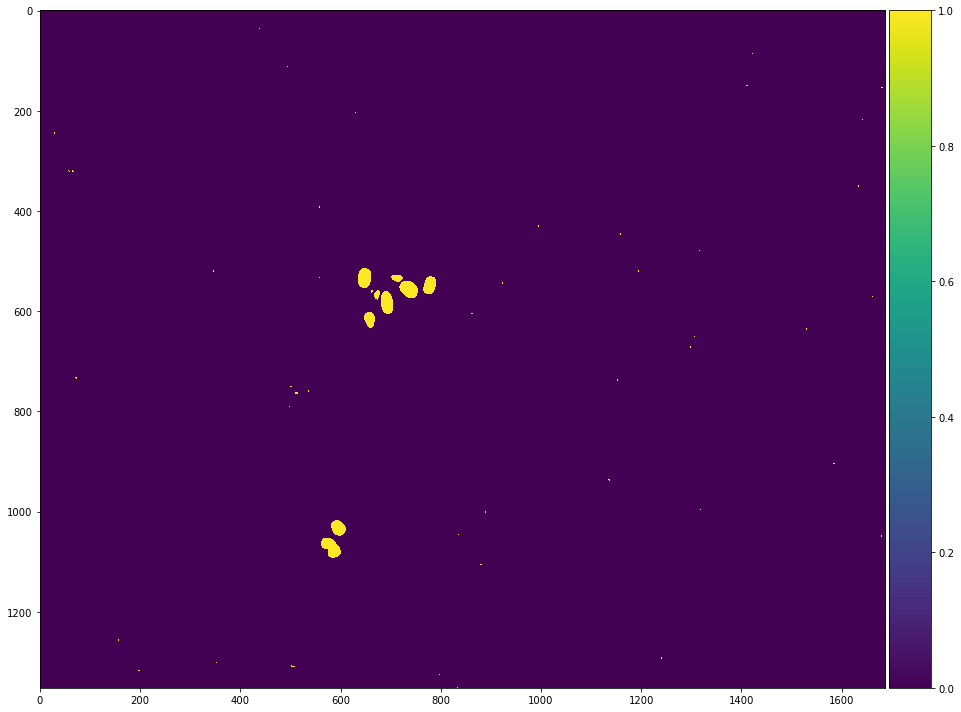

In [29]:
imshow(binary_erosion(labels).astype(int))

In [43]:
fn

'/home/nathan/data/kraken/ras//ND0018/Pos9/Pos9_images/img_channel098_position009_time000000006_z000.tif'

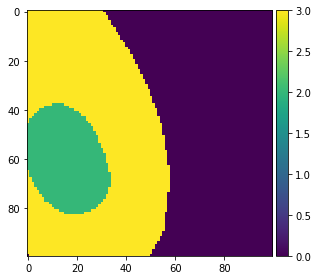

In [42]:
imshow(mask[300:400,750:850])

In [ ]:
%%time
for expt in tqdm(sorted(['ND0022'])):
    pos_list = ['Pos12']#sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                         if 'Pos' in pos 
#                         and os.path.isdir(f'{root_dir}/{expt}/{pos}')],
#                         key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
    for pos in tqdm(pos_list):

        print('Starting experiment position:', expt, pos)
        # load images
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
        images = DaskOctopusLiteLoader(image_path, 
                                       remove_background = True)

        # iterate over images filenames 
        for frame, fn in tqdm(enumerate(images.files(reference_channel)),total = len(images.files(reference_channel))):
#             if os.path.exists(((images.files('irfp')[frame])).replace('channel003', 'channel099')):
#                 continue
            # load two seperate images
            gfp = imread(fn)
            # predict labels using 2 instances of the model with different params
            labels, details = model.predict_instances(normalize(gfp), prob_thresh=0.7)
            # format 2channel mask image 
            mask = np.zeros(labels.shape)
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = nd.binary_erosion(labels==i)
                mask[segment] = 1 ## for gfp
                # set background to zero
                mask[labels == 0] = 0
#             # now do the same for the rfp channel
#             rfp = imread(fn.replace('channel001', 'channel002'))   
#             # predict labels using 2 instances of the model with different params
#             labels, details = model.predict_instances(normalize(rfp), prob_thresh=0.2)
#             for i in range(1, np.amax(labels)):
#                 #needs erosion step to stop merging of labels
#                 segment = nd.binary_erosion(labels==i)
#                 mask[segment] = 2 ## for rfp

            # set filename as mask format (channel099)
            fn = ((images.files('gfp')[frame])).replace('channel001', 'channel097')
            # save out labelled image
            imsave(fn, mask.astype(np.uint8), check_contrast=False)
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Starting experiment position: ND0022 Pos12


  0%|          | 0/1098 [00:00<?, ?it/s]

In [ ]:
%%time
for expt in tqdm(sorted(['ND0022'])):
    pos_list = ['Pos12']#sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                         if 'Pos' in pos 
#                         and os.path.isdir(f'{root_dir}/{expt}/{pos}')],
#                         key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
    for pos in tqdm(pos_list):

        print('Starting experiment position:', expt, pos)
        # load images
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
        images = DaskOctopusLiteLoader(image_path, 
                                       remove_background = True)

        # iterate over images filenames 
        for frame, fn in tqdm(enumerate(images.files(reference_channel)),total = len(images.files(reference_channel))):
#             if os.path.exists(((images.files('irfp')[frame])).replace('channel003', 'channel099')):
#                 continue
            # load two seperate images
            gfp = imread(fn)
            # predict labels using 2 instances of the model with different params
            labels, details = model.predict_instances(normalize(gfp))
            # format 2channel mask image 
            mask = np.zeros(labels.shape)
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = nd.binary_erosion(labels==i)
                mask[segment] = 1 ## for gfp
                # set background to zero
                mask[labels == 0] = 0
            # now do the same for the rfp channel
            rfp = imread(fn.replace('channel001', 'channel002'))   
            # predict labels using 2 instances of the model with different params
            labels, details = model.predict_instances(normalize(rfp))
            for i in range(1, np.amax(labels)):
                #needs erosion step to stop merging of labels
                segment = nd.binary_erosion(labels==i)
                mask[segment] = 2 ## for rfp

            # set filename as mask format (channel099)
            fn = ((images.files('gfp')[frame])).replace('channel001', 'channel097')
            # save out labelled image
            imsave(fn, mask.astype(np.uint8), check_contrast=False)
        